In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
N_SIMULATIONS = int(1e5)  # 100k simulation runs
N_YEARS = 10  # Run for 5 years
REVENUE_START = 100  # Revenue in year -1
EXPENSES_START = 93  # Expenses in year -1
CASH_START = 1  # 1 unit of cash in the bank in year -1
PROFITMARGIN_TARGET = 0.07  # 7% profit margin target

- Revenue growth year on year is 5% with standard deviation of 0.05
- If we miss the profit margin target we reduce the expenses in the next year with 75% probability
    - We might not be able to reduce fixed expenses immediately so with 25% probability expenses remain unchanged
- If we exceed the targeted profit margin we increase expenses with 75% probability
    - Same here. We might not be able to e.g. hire more people immediately
- Biggest customer generates between 15 and 30% of revenue
- Yearly chance of losing the biggest customer is 10%

In [3]:
# Sample our random variables
revenue_growth = np.random.normal(1.05, 0.05, size=(N_YEARS, N_SIMULATIONS))
can_change_expenses = np.random.rand(N_YEARS, N_SIMULATIONS) < 0.75  # boolean
biggest_customer_share = np.random.uniform(0.15, 0.3, size=(N_YEARS, N_SIMULATIONS))
biggest_customer_leaves = np.random.rand(N_YEARS, N_SIMULATIONS) < 0.1  # boolean

In [4]:
# Init container matrices for calculated values
revenues = np.zeros((N_YEARS, N_SIMULATIONS))
profits = np.zeros((N_YEARS, N_SIMULATIONS))
expenses = np.zeros((N_YEARS, N_SIMULATIONS))
cash = np.zeros((N_YEARS, N_SIMULATIONS))

In [5]:
for i in range(N_YEARS):
    if i == 0:
        # first year
        prev_revenue = REVENUE_START * np.ones(N_SIMULATIONS)
        prev_expenses = EXPENSES_START * np.ones(N_SIMULATIONS)
        prev_cash = CASH_START * np.ones(N_SIMULATIONS)
    else:
        prev_revenue = revenues[i-1,:]
        prev_expenses = expenses[i-1,:]
        prev_cash = cash[i-1,:]
    prev_expenses_target = prev_revenue * (1 - PROFITMARGIN_TARGET)
    revenues[i,:] = prev_revenue * revenue_growth[i,:]
    expenses[i,:] = np.where(can_change_expenses[i,:], prev_expenses_target, prev_expenses)
    revenue_from_biggest_customer = biggest_customer_share[i,:] * revenues[i,:]
    revenues[i,:] = np.where(
        biggest_customer_leaves[i,:],
        revenues[i,:] - revenue_from_biggest_customer,
        revenues[i,:]
    )
    profits[i,:] = revenues[i,:] - expenses[i,:]
    cash[i,:] = prev_cash + profits[i,:]

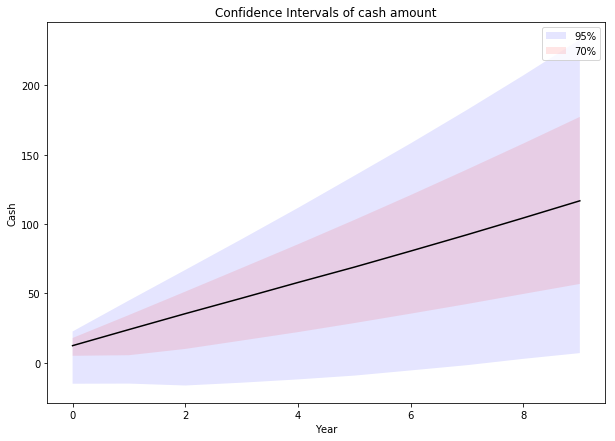

In [6]:
# Median, 70%, 95% interval
plt.figure(figsize=(10, 7))
plt.fill_between(np.arange(N_YEARS), *np.percentile(cash, [2.5, 97.5], axis=1), facecolor='b', alpha=0.1, label='95%');
plt.fill_between(np.arange(N_YEARS), *np.percentile(cash, [15, 85], axis=1), facecolor='r', alpha=0.1, label='70%');
plt.plot(np.percentile(cash, 50, axis=1), c='k');
plt.legend()
plt.title('Confidence Intervals of cash amount')
plt.xlabel('Year')
plt.ylabel('Cash');

Text(0,0.5,'Cash')

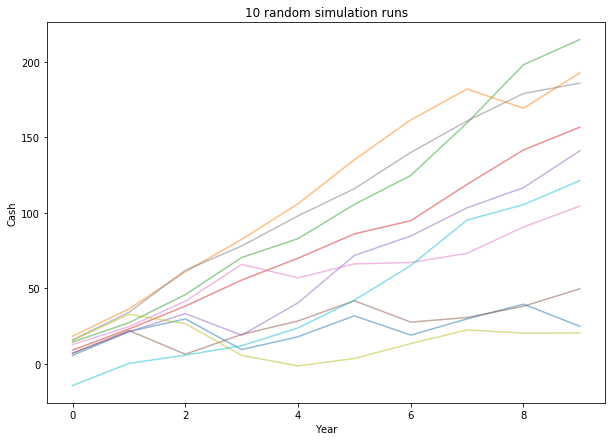

In [7]:
# Plot cash of 10 different simulation runs
plt.figure(figsize=(10, 7))
plt.plot(cash[:,:10], alpha=0.5);
plt.title('10 random simulation runs')
plt.xlabel('Year')
plt.ylabel('Cash')

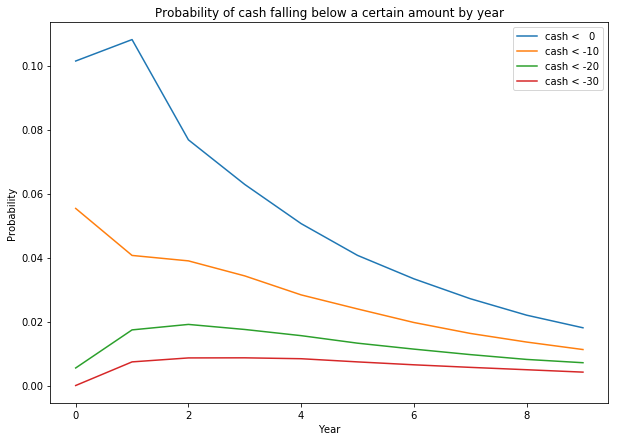

In [8]:
plt.figure(figsize=(10, 7))
for i in [0, -10, -20, -30]:
    plt.plot((cash < i).sum(1) / N_SIMULATIONS, label='cash < {: 3.0f}'.format(i))
plt.title('Probability of cash falling below a certain amount by year');
plt.legend();
plt.xlabel('Year');
plt.ylabel('Probability');

In [9]:
for i in [0, -10, -20, -30]:
    print("Probability of cash dropping below {: 3.0f} in any year: {:0.2f}%".format(
            i, 100 * (cash < i).sum(1).max() / N_SIMULATIONS))

Probability of cash dropping below   0 in any year: 10.81%
Probability of cash dropping below -10 in any year: 5.53%
Probability of cash dropping below -20 in any year: 1.91%
Probability of cash dropping below -30 in any year: 0.86%


In [10]:
for i in [51, 95, 99]:
    print('With {}% probability cash is always more than: {: 3.2f}'.format(
            i, np.percentile(cash, 100-i, axis=1).min()))

With 51% probability cash is always more than:  12.17
With 95% probability cash is always more than: -10.87
With 99% probability cash is always more than: -28.29
